# Imports

In [2]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax
from theano import function
from scipy.misc import imread
from data_preprocessing import *
from sklearn.linear_model import LogisticRegression

import sklearn
import theano
import time

import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt
import os
import pickle
import lasagne
import itertools

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


In [3]:
MEAN_VALUES = np.array([104, 117, 123], dtype=np.float32).reshape(1, 3, 1, 1)
 
def preprocess(img):
    return np.rollaxis(img, 2)[::-1][None] - MEAN_VALUES


def deprocess(img):
    return np.transpose((img + MEAN_VALUES)[0, ::-1], (1, 2, 0))


def featurize(X):
    data = [None] * len(X)

    for i, img in enumerate(X):
        img = proportional_resize(img)
        data[i] = features(preprocess(img)).ravel()

    return data


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Build simple model

In [4]:
def build_simple_model(input_shape):
    net = {}
    
    net['input'] = InputLayer((None, input_shape[2], input_shape[0], input_shape[1]))
    
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)
    
    
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

# Load pretrained net params

In [5]:
with open('vgg19.pkl', 'rb') as f:
    params = pickle.load(f)

In [6]:
img_dir = 'leftImg8bit'
images_path = os.path.join(CITYSCAPESPATH, img_dir)

first_img_path = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(images_path)) for f in fn][0]
img = imread(first_img_path)
first_img = proportional_resize(img)
net = build_simple_model(first_img.shape)

In [7]:
last_vgg_layer = net['pool5']
lasagne.layers.set_all_param_values(last_vgg_layer, params['param values'][:32])

In [8]:
input_X = T.tensor4('X')

output = lasagne.layers.get_output(last_vgg_layer, input_X, deterministic = True)
features = function([input_X], output)

### Data loading

In [9]:
def load_data(modes, *args, **kwargs):
    cities = get_cities()
    dataset = prepare_dataset(
            itertools.chain(*[zip(ReadFilePaths(mode, city, 'leftImg8bit'),
                                  ReadFilePaths(mode, city, 'gtFine', 'gtFine_color.png'),
                                  ReadFilePaths(mode, city, 'disparity'))
                            for mode in modes for city in cities[mode]]), *args, **kwargs)
    return zip(*dataset)

In [9]:
%%time

data_filename = 'data_basic.pkl'

if os.path.exists(data_filename):
    with open(data_filename, 'rb') as f:
        X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
else:
    X_val, Seg_val, y_val = load_data(['val'], False, 7)
    X_train, Seg_train, y_train = load_data(['train'], False, 7)
    X_test, Seg_test, y_test = load_data(['test'], False, 7)

    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    Seg_test = np.array(Seg_test)
    Seg_train = np.array(Seg_train)
    Seg_val = np.array(Seg_val)
    
    with open(data_filename, 'wb') as f:
        pickle.dump((X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test), f)

CPU times: user 16.5 s, sys: 2.25 s, total: 18.8 s
Wall time: 22.5 s


In [49]:
%%time

data_filename = 'data_rem_road.pkl'

if os.path.exists(data_filename):
    with open(data_filename, 'rb') as f:
        X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
else:
    X_val, Seg_val, y_val = load_data(['val'], True, 4)
    X_train, Seg_train, y_train = load_data(['train'], True, 4)
    X_test, Seg_test, y_test = load_data(['test'], True, 4)

    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    Seg_test = np.array(Seg_test)
    Seg_train = np.array(Seg_train)
    Seg_val = np.array(Seg_val)
    
    with open(data_filename, 'wb') as f:
        pickle.dump((X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test), f)

CPU times: user 17.9 s, sys: 6.24 s, total: 24.1 s
Wall time: 24.1 s


In [12]:
%%time
f1_val = featurize(X_val)
f1_train = featurize(X_train)
f1_test = featurize(X_test)
f2_val = featurize(Seg_val)
f2_train = featurize(Seg_train)
f2_test = featurize(Seg_test)

CPU times: user 2min 20s, sys: 41.4 s, total: 3min 1s
Wall time: 3min 1s


In [13]:
len(f1_train), f1_train[0].shape

(2975, (18432,))

In [19]:
with open('features_basic.pkl', 'wb') as f:
    pickle.dump((f1_train, f1_val, f1_test, f2_train, f2_val, f2_test), f)

In [11]:
with open('features_basic.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)

(array([  16.,   49.,   88.,  163.,  109.,  125.,  120.,  113.,  127.,
         106.,  132.,  134.,  115.,  195.,  295.,  368.,  252.,  131.,
         125.,  212.]),
 array([  14. ,   19.6,   25.2,   30.8,   36.4,   42. ,   47.6,   53.2,
          58.8,   64.4,   70. ,   75.6,   81.2,   86.8,   92.4,   98. ,
         103.6,  109.2,  114.8,  120.4,  126. ]),
 <a list of 20 Patch objects>)

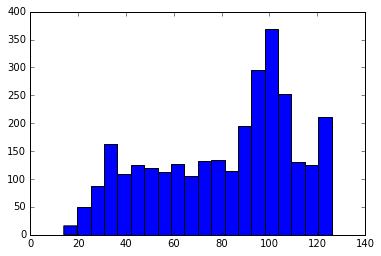

In [38]:
plt.hist(y_train, bins=20)

In [13]:
y_train

array([ 60, 105,  42, ...,  83,  18,  50], dtype=uint8)

In [50]:
bins = [np.percentile(y_train, 0),
#         np.percentile(y_train, 10),
        np.percentile(y_train, 25),
#         np.percentile(y_train, 30),
#         np.percentile(y_train, 40),
        np.percentile(y_train, 50),
#         np.percentile(y_train, 60),
        np.percentile(y_train, 75),
#         np.percentile(y_train, 80),
#         np.percentile(y_train, 90),
        np.percentile(y_train, 100) + 1]

In [51]:
bins

[14.0, 57.0, 89.0, 103.0, 127.0]

In [52]:
y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

(array([ 739.,    0.,    0.,  715.,    0.,    0.,  721.,    0.,    0.,  800.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

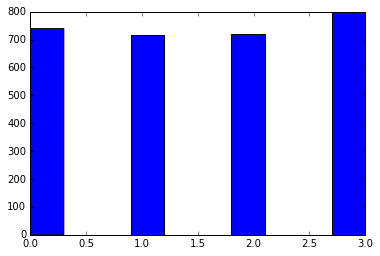

In [53]:
plt.hist(y_train)

# With the road

In [31]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(f1_train, y_train).score(f1_val, y_val)

0.73199999999999998

# With the road + segmentation

In [32]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(np.hstack((np.array(f1_train), np.array(f2_train))), y_train).score(np.hstack((np.array(f1_val), np.array(f2_val))), y_val)

0.82399999999999995

# Road deleted

In [40]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(f1_train, y_train).score(f1_val, y_val)

0.88400000000000001

# Road deleted + segmentation

In [41]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(np.hstack((np.array(f1_train), np.array(f2_train))), y_train).score(np.hstack((np.array(f1_val), np.array(f2_val))), y_val)

0.86799999999999999

# Simple perceptron

In [43]:
input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=4096)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=4096)
dr3 = DropoutLayer(ll2, p=0.5)
percentile = DenseLayer(dr3, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')

input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

In [44]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

[W, b, W, b, W, b]


In [45]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
# loss += lasagne.regularization.l1(all_weights) * 0.001
# loss += lasagne.regularization.l2(all_weights) * 0.001

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.01)

In [46]:
#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

In [47]:
num_epochs = 30 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 30 took 3.776s
  training loss (in-iteration):		1047.817674
  train accuracy:		16.69 %
  validation accuracy:		25.00 %
Epoch 2 of 30 took 3.748s
  training loss (in-iteration):		2.871897
  train accuracy:		27.45 %
  validation accuracy:		27.20 %
Epoch 3 of 30 took 3.753s
  training loss (in-iteration):		1.556400
  train accuracy:		41.34 %
  validation accuracy:		29.80 %
Epoch 4 of 30 took 3.755s
  training loss (in-iteration):		1.315371
  train accuracy:		48.79 %
  validation accuracy:		31.40 %
Epoch 5 of 30 took 3.786s
  training loss (in-iteration):		1.149465
  train accuracy:		55.48 %
  validation accuracy:		34.00 %
Epoch 6 of 30 took 3.762s
  training loss (in-iteration):		1.006941
  train accuracy:		61.24 %
  validation accuracy:		34.60 %
Epoch 7 of 30 took 3.751s
  training loss (in-iteration):		0.920065
  train accuracy:		64.90 %
  validation accuracy:		33.80 %
Epoch 8 of 30 took 3.753s
  training loss (in-iteration):		0.850599
  train accuracy:		68.14 %
  validation 

KeyboardInterrupt: 